# 1. 초기화
import lots of modules and set up filters regarding raw data

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import font_manager, rc

rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False   

column_filter = ['배송자휴대전화번호', 'T기프트배송자휴대전화번호', '주문번호', '주문일', '취소일', '결제일', '개통일', '배송일', '모델명', '가입유형', '약정프로그램', '요금제', '무약정Plan선택여부', 
                        '결제방법', '배송방법', '대리점', '주문유형', '쿠폰여부', '지인(추천인)코드', '개통일자', '센터명', '모바일구매여부', '상품구분(맞춤/패키지)', 
                        '서비스관리번호', 'TG상태값', '주문구분', '상담사소속', '대리점코드(중분류)', '외부유입경로', '약정구분', '포인트결제', '동의방법', 
                        '뉴보상기변 쓰던폰반납여부', '오늘보상 신청여부', '오늘보상 수거상태', '클럽기변 신청서 상태', 'T 갤럭시 클럽', '클럽기변 단말기할부금 면제금액', 
                        '대리점명', '매장명', 'D코드', '발송일']

# 개별 데이터를 상반부와 하반부를 합쳐서 생성

In [ ]:
# 기준이 되는 24일 ars 인입 고객 정보 로딩 - 나이 연령 정보 포함됨
customer_24 = pd.DataFrame(pd.read_csv('./access_nums_age_sex.csv'),columns=['전화번호', '나이', '성별'])
customer_24

## 8월 24일 상담센터 인입고객 성별 비율 계산 및 시각화

In [38]:
## 24일 인입된 데이터에 대해서 성별로 정리해서 개수를 세도록 한다.
pivot_sex = pd.pivot_table(customer_24, index="성별", values=['전화번호'], aggfunc='count')
display(pivot_sex)


,전화번호
성별,
#,32
B,47
남,5105
여,3438


<AxesSubplot:ylabel='전화번호'>

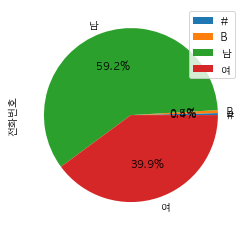

In [37]:
pivot_sex.plot.pie(y="전화번호", autopct='%1.1f%%')

### 위 차트 상으로 남자가 비중이 높다고 볼 수 있지만, 이 내용만으로 유의미한 결론이 나오지 않는다. 오히려, 성별과 나이대를 계산 hitmap을 그리도록 하자

In [39]:
## 히트맵 계산을 위해서, 나이대를 10 살 단위 기준으로 데이터를 정형화 하도록 한다.
## 이를 위해서 기존 데이터에 신규 칼럼 - "연령대" 을 추가하도록 하자.



In [ ]:
# 모바일 주문 정보 로딩 
mobile_order_1 = pd.DataFrame (pd.read_csv('./1_m.csv'), columns=column_filter)
mobile_order_2 = pd.DataFrame (pd.read_csv('./2_m.csv'), columns=column_filter)
mobile_orders = pd.concat([mobile_order_1, mobile_order_2], ignore_index=True, axis=0)
mobile_orders.reset_index(drop=True)
print (mobile_orders.loc[15, :])

In [ ]:
# 바로픽업 정보들 로딩
pickup_order_1 = pd.DataFrame (pd.read_csv('./1_b.csv'), columns=column_filter)
pickup_order_2 = pd.DataFrame (pd.read_csv('./2_b.csv'), columns=column_filter)
pickup_orders = pd.concat([pickup_order_1, pickup_order_2], ignore_index=True, axis=0)
pickup_orders.reset_index(drop=True)
print (pickup_orders.loc[15, :])

In [ ]:
# build up a merged dataframe that includes all data (mobile and pickup)

orders = pd.concat([mobile_orders, pickup_orders], ignore_index=True, axis=0)
orders

print(orders['배송자휴대전화번호'])